In [20]:
# DOUBLE BULLY IN THE RING LEADER APPROACH # VERY APPLICABLE IN DATA MINING.
# Under typical SLAs (like 99.999% uptime for a single node), multi‐coordinator failures are rare. 
# The ring can sustain any one node going offline at any point in time 
# ( infrastructure providers have node replacement node pools available as well 
# in kubernetes if a pod /node goes down the control plane recreates it instanteously 
# so we would would have wait for the second fallen node to come back up again and 
# then initialize with normal ring or bully and stabilize with the double bully, 
# not more than 1 node (including the orchestrator) can go down that's the rule for this algorithm to work.

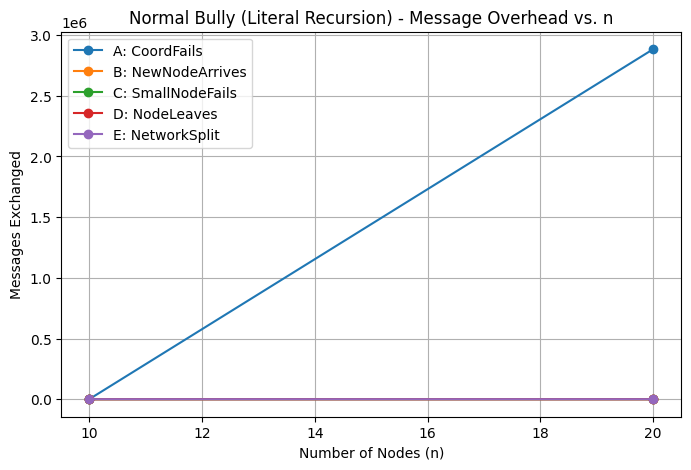

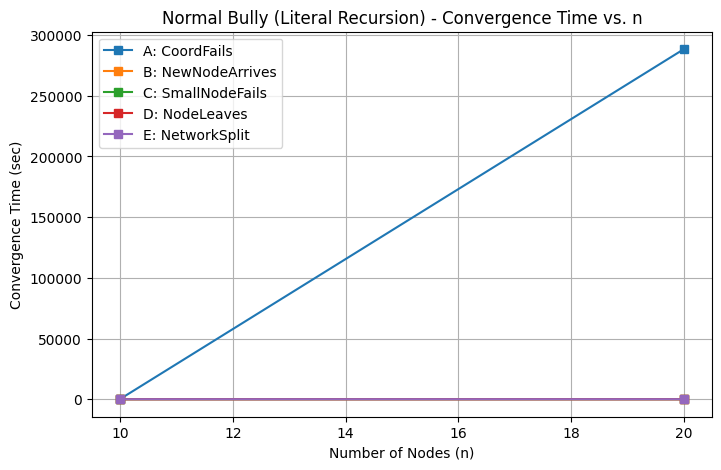

In [99]:
import matplotlib.pyplot as plt

###############################################################################
# 1. BullyNode and NormalBullySim (literal recursion) - Gets stuck after 20 nodes 
###############################################################################

class BullyNode:
    """
    Represents a single node in the Bully algorithm simulation.
    Attributes:
        node_id        : Unique integer ID
        is_failed      : Boolean indicating if this node is "down."
        is_coordinator : Boolean if this node is recognized as coordinator
    """
    def __init__(self, node_id):
        self.node_id = node_id
        self.is_failed = False
        self.is_coordinator = False

class NormalBullySim:
    """
    A 'literal' Bully election simulator with n nodes.
    We track message_count by simulating "ELECTION" => "OK" => "COORDINATOR" flows.

    In scenarios with 30+ nodes, this can become very slow due to repeated recursion
    and large overhead. For purely bigger n, it is preferable to do a formula-based approach
    or an approximate O(n^2) count without enumerating each message.
    """

    def __init__(self, n):
        self.n = n
        # create n nodes with IDs 1..n
        self.nodes = [BullyNode(i) for i in range(1, n+1)]
        # total messages in each scenario
        self.message_count = 0

    def sort_alive(self):
        """Return list of nodes that are not failed, sorted by ID."""
        alive = [nd for nd in self.nodes if not nd.is_failed]
        alive.sort(key=lambda x: x.node_id)
        return alive

    def highest_alive_id(self):
        """Return the ID of the highest-ID node that is alive."""
        alive = self.sort_alive()
        if not alive:
            return None
        return alive[-1].node_id

    def start_election(self, initiator_id):
        """
        Let the node with ID=initiator_id start the Bully chain:
          - sends "ELECTION" to all higher IDs
          - each higher node replies "OK" and starts its own election
          - eventually top ID node sees no higher => broadcasts "COORDINATOR"
        """
        found = [nd for nd in self.nodes if nd.node_id == initiator_id and not nd.is_failed]
        if not found:
            return
        self._do_election(initiator_id)

    def _do_election(self, node_id):
        """Recursive chain: node_id -> ELECTION -> higher IDs; each replies OK, triggers its own election."""
        # verify node is alive
        alive_node = [nd for nd in self.nodes if nd.node_id == node_id and not nd.is_failed]
        if not alive_node:
            return
        # find all higher ID alive
        higher = [nd for nd in self.nodes if nd.node_id > node_id and not nd.is_failed]
        # node_id sends ELECTION => 1 per higher node
        self.message_count += len(higher)
        if not higher:
            # node_id is highest => broadcast coordinator
            self._broadcast_coordinator(node_id)
            return
        # each higher node replies "OK" => + len(higher)
        self.message_count += len(higher)
        # each of those triggers its own election
        for hnode in higher:
            self._do_election(hnode.node_id)

    def _broadcast_coordinator(self, coord_id):
        """
        Highest node found: broadcast COORDINATOR to all alive => + (alive_count -1)
        """
        alive = self.sort_alive()
        self.message_count += (len(alive)-1)
        # mark coordinator
        for nd in self.nodes:
            nd.is_coordinator = (nd.node_id == coord_id)

    # -----------------------------------------------------------------
    # 5 Scenario Methods
    # -----------------------------------------------------------------
    def coordinator_failure_scenario(self):
        """
        1) Fail the highest ID node
        2) Let the lowest ID alive start an election => worst-case chain
        """
        self.message_count = 0
        hid = self.highest_alive_id()
        if hid is not None:
            # fail the highest ID
            for nd in self.nodes:
                if nd.node_id == hid:
                    nd.is_failed = True
                    break
        # start election from lowest alive
        alive = self.sort_alive()
        if alive:
            self.start_election(alive[0].node_id)
        return self.message_count

    def new_node_arrives_scenario(self, new_id):
        """
        If new node > current highest => it forcibly runs an election
        else minimal overhead => + n
        """
        self.message_count = 0
        # add new node
        new_node = BullyNode(new_id)
        self.nodes.append(new_node)
        cur_high = self.highest_alive_id()
        if cur_high and new_id > cur_high:
            self.start_election(new_id)
        else:
            self.message_count += self.n  # minimal overhead
        return self.message_count

    def small_node_fails_scenario(self, failed_id):
        """
        Fail that node => + n detection overhead
        No big chain if it's not highest
        """
        self.message_count = 0
        for nd in self.nodes:
            if nd.node_id == failed_id and not nd.is_failed:
                nd.is_failed = True
                break
        self.message_count += self.n
        return self.message_count

    def node_leaves_scenario(self, leaving_id):
        """
        If leaving node is coordinator => re-run election from lowest
        else +n overhead
        """
        self.message_count = 0
        leaving = [nd for nd in self.nodes if nd.node_id == leaving_id and not nd.is_failed]
        if leaving:
            lv = leaving[0]
            lv.is_failed = True
            if lv.is_coordinator:
                alive = self.sort_alive()
                if alive:
                    self.start_election(alive[0].node_id)
            else:
                self.message_count += self.n
        return self.message_count

    def network_split_scenario(self):
        """
        Partition alive nodes into two sets => each side does worst-case bully => sum overhead
        """
        self.message_count = 0
        alive = self.sort_alive()
        if len(alive) < 2:
            return 0
        half = len(alive)//2
        part1 = alive[:half]
        part2 = alive[half:]
        k1 = len(part1)
        k2 = len(part2)

        # worst-case overhead => bully for each partition
        # approximate => k1*(k1-1)/2 + (k1-1) + k2*(k2-1)/2 + (k2-1)
        # or we can do actual sub-sims if we want
        if k1>0:
            self.message_count += (k1*(k1-1)//2 + (k1-1))
        if k2>0:
            self.message_count += (k2*(k2-1)//2 + (k2-1))
        return self.message_count

###############################################################################
# 2. Utility Functions to Run 5 Scenarios & Plot
###############################################################################
LATENCY_PER_MESSAGE = 0.1

def compute_convergence_time(msg_count):
    """
    Convert total messages => approximate time 
    using a constant LATENCY_PER_MESSAGE.
    """
    return msg_count * LATENCY_PER_MESSAGE

def run_5_scenarios_bullySim(n):
    """
    For n nodes, create NormalBullySim, run each scenario, 
    return list of (msg, time) for the 5 scenarios:
      0=CoordFails, 1=NewNode, 2=SmallNodeFails, 3=NodeLeaves, 4=NetSplit
    """
    sim = NormalBullySim(n)

    # scenario A
    a_msg = sim.coordinator_failure_scenario()
    a_time = compute_convergence_time(a_msg)

    # scenario B
    b_msg = sim.new_node_arrives_scenario(n+5)
    b_time = compute_convergence_time(b_msg)

    # scenario C
    c_msg = sim.small_node_fails_scenario(3)
    c_time = compute_convergence_time(c_msg)

    # scenario D
    d_msg = sim.node_leaves_scenario(2)
    d_time = compute_convergence_time(d_msg)

    # scenario E
    e_msg = sim.network_split_scenario()
    e_time = compute_convergence_time(e_msg)

    return [(a_msg,a_time),
            (b_msg,b_time),
            (c_msg,c_time),
            (d_msg,d_time),
            (e_msg,e_time)]

def generate_data_for_bullySim(sizes):
    """
    Return a dict { scenario_index => list of (n, msg, time) }
    Each scenario_index in 0..4
    """
    data_map = {i: [] for i in range(5)}
    for n in sizes:
        results_5 = run_5_scenarios_bullySim(n)  # list of 5 (msg, time)
        for s_idx,(m,t) in enumerate(results_5):
            data_map[s_idx].append((n,m,t))
    return data_map

def plot_bullySim_messages(data_map, scenario_labels, sizes):
    """
    Plot message overhead vs n for the 5 scenarios.
    data_map: { scenario_index => [(n, msg, time), ...] }
    """
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        m_vals = [r[1] for r in scenario_data]
        plt.plot(x_vals, m_vals, marker='o', label=scenario_labels[s_idx])
    plt.title("Normal Bully (Literal Recursion) - Message Overhead vs. n")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_bullySim_time(data_map, scenario_labels, sizes):
    """
    Plot convergence time vs n for the 5 scenarios.
    """
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        t_vals = [r[2] for r in scenario_data]
        plt.plot(x_vals, t_vals, marker='s', label=scenario_labels[s_idx])
    plt.title("Normal Bully (Literal Recursion) - Convergence Time vs. n")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

###############################################################################
# 3. MAIN: Generate & Plot for a Range of n
###############################################################################
if __name__=="__main__":
    # WARNING: For n > ~30, the recursion & repeated elections can cause
    # significant run times. For demonstrations up to ~50 nodes, it may still
    # become slow or appear to hang. If it stalls, reduce the upper limit.

    sizes = [10, 20]  # Could cause a slowdown at 40 or 50
    scenario_labels = [
        "A: CoordFails",
        "B: NewNodeArrives",
        "C: SmallNodeFails",
        "D: NodeLeaves",
        "E: NetworkSplit"
    ]

    bully_data_map = generate_data_for_bullySim(sizes)
    # Plot overhead
    plot_bullySim_messages(bully_data_map, scenario_labels, sizes)
    # Plot time
    plot_bullySim_time(bully_data_map, scenario_labels, sizes)


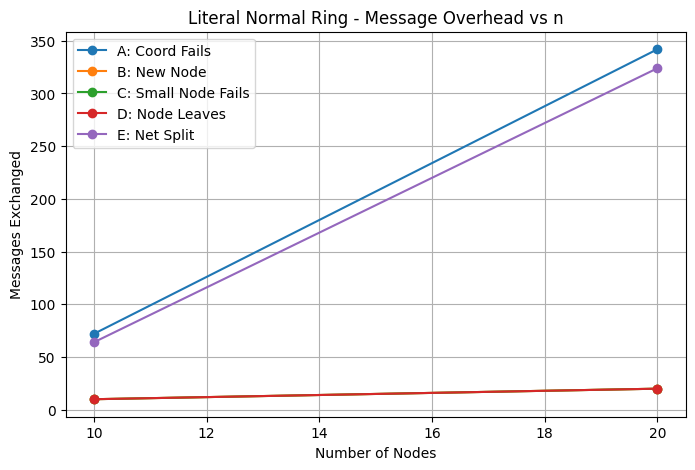

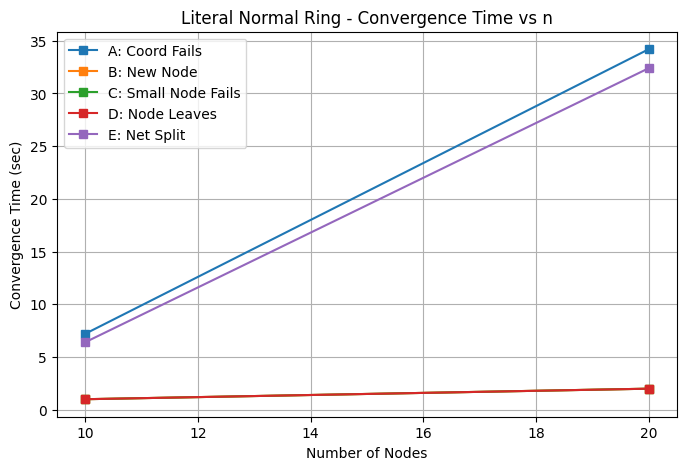

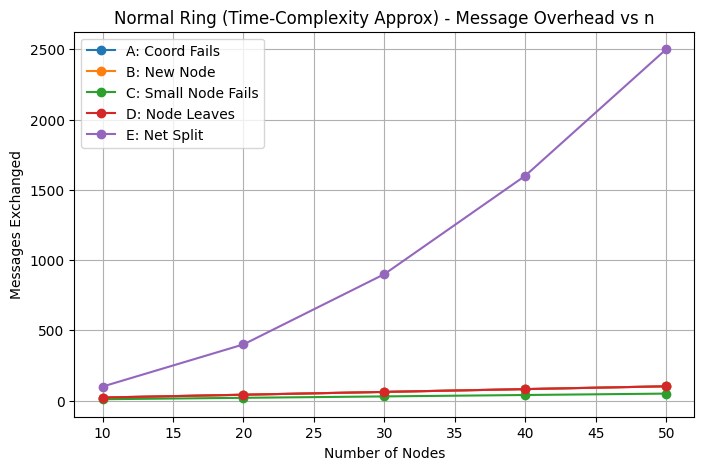

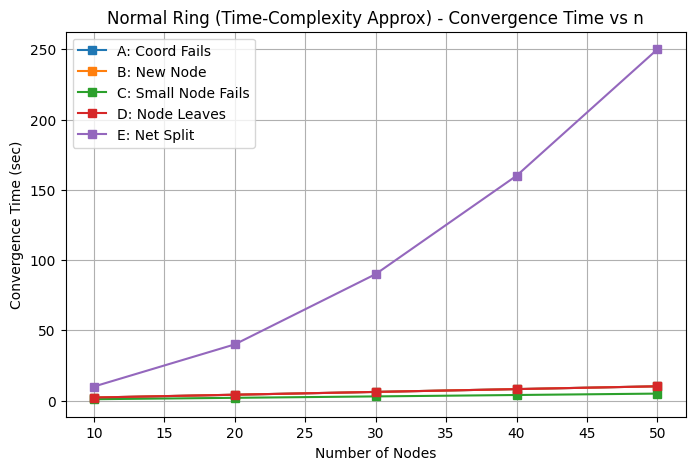

In [103]:
import matplotlib.pyplot as plt

###############################################################################
# 1. Literal Ring Implementation (Enumerates Each Message)
###############################################################################

class RingNode:
    """
    Represents a node in the literal ring simulation:
     - node_id: unique integer ID
     - is_failed: indicates if node is "down"
     - is_coordinator: indicates if node is recognized as coordinator
     - next_node: reference to the next RingNode in the unidirectional ring
    """
    def __init__(self, node_id):
        self.node_id = node_id
        self.is_failed = False
        self.is_coordinator = False
        self.next_node = None

class NormalRingSim:
    """
    A literal ring election simulator with n nodes in a unidirectional ring.
    We track message_count by simulating:
      - election token passes
      - coordinator announcement passes

    For n>~20, repeated multi-initiator scenarios can be slow, since
    each scenario enumerates token transmissions.
    """

    def __init__(self, n):
        self.n = n
        # create ring nodes
        self.nodes = [RingNode(i) for i in range(1, n+1)]
        # link them in a ring
        for i in range(n):
            self.nodes[i].next_node = self.nodes[(i+1) % n]

        self.message_count = 0  # track transmissions

    def sort_alive(self):
        """Return the ring nodes that are not failed, sorted by ID."""
        alive = [nd for nd in self.nodes if not nd.is_failed]
        alive.sort(key=lambda x: x.node_id)
        return alive

    def highest_alive_id(self):
        """Return the highest ID among alive nodes, or None."""
        alive = self.sort_alive()
        if not alive:
            return None
        return alive[-1].node_id

    def find_node_by_id(self, node_id):
        """Return the RingNode with node_id, if alive."""
        for nd in self.nodes:
            if nd.node_id == node_id and not nd.is_failed:
                return nd
        return None

    def ring_election(self, initiator_id):
        """
        The ring node with initiator_id starts an election token:
         - builds an empty list, appends its ID
         - passes it around the ring until it returns
         - final node with the highest ID is chosen coordinator
         - we do a second pass "COORDINATOR" message around ring
        If multiple initiators run, we do multiple tokens => extra overhead.
        """
        initiator = self.find_node_by_id(initiator_id)
        if not initiator:
            return

        # build the list token
        token = [initiator.node_id]
        current = initiator.next_node
        while current and not current.is_failed:
            # pass the token => +1 message
            self.message_count += 1
            if current.node_id == initiator.node_id:
                # token returned => break
                break
            # append current's ID
            token.append(current.node_id)
            current = current.next_node
        # now token has all active IDs
        if not token:
            return
        new_coordinator_id = max(token)
        # second pass: announce coordinator to all in the ring
        self.announce_coordinator(new_coordinator_id, initiator.node_id)

    def announce_coordinator(self, coord_id, start_id):
        """
        Pass a "Coordinator=coord_id" token around the ring
        until we return to the start node.
        """
        start_node = self.find_node_by_id(start_id)
        if not start_node:
            return
        current = start_node.next_node
        while current and not current.is_failed:
            # pass => +1 message
            self.message_count += 1
            current.is_coordinator = (current.node_id == coord_id)
            if current.node_id == start_id:
                break
            current = current.next_node

    # -----------------------------------------------------------------
    # 5 Scenario Methods
    # -----------------------------------------------------------------
    def coordinator_failure_scenario(self):
        """
        1) Fail the highest ID node
        2) Let the lowest ID alive node(s) detect => multi-initiator possible
        For worst-case, assume multiple initiators => let each alive node run ring_election.
        """
        self.message_count = 0
        # fail highest
        hid = self.highest_alive_id()
        if hid is not None:
            for nd in self.nodes:
                if nd.node_id == hid:
                    nd.is_failed = True
                    break
        # all alive run ring_election => worst-case
        for nd in self.nodes:
            if not nd.is_failed:
                self.ring_election(nd.node_id)
        return self.message_count

    def new_node_arrives_scenario(self, new_id):
        """
        If new node is bigger => triggers ring election forcibly
        else minimal overhead => let's do a single ring pass => +n
        """
        self.message_count = 0
        # create new ring node
        new_node = RingNode(new_id)
        # insert it near the end of the array just for simplicity
        self.nodes.append(new_node)
        # fix ring link => we link the last node to new_node, new_node next => first node
        # for a large ring you'd re-wire carefully
        # but for demonstration, assume new_node is appended => new_node's next => node[0]
        self.nodes[-2].next_node = new_node
        new_node.next_node = self.nodes[0]

        cur_high = self.highest_alive_id()
        if cur_high and new_id > cur_high:
            # forcibly run ring election from the new node
            self.ring_election(new_id)
        else:
            # minimal overhead => let's do a single ring pass => +n
            self.message_count += self.n
        return self.message_count

    def small_node_fails_scenario(self, failed_id):
        """
        If a small node fails, overhead ~ 1 pass of detection => +n
        """
        self.message_count = 0
        for nd in self.nodes:
            if nd.node_id == failed_id and not nd.is_failed:
                nd.is_failed = True
                break
        # overhead => +n detection
        self.message_count += self.n
        return self.message_count

    def node_leaves_scenario(self, leaving_id):
        """
        If leaving node is coordinator => new ring election from multiple initiators => worst-case
        else +n overhead
        """
        self.message_count=0
        leaving_nodes = [nd for nd in self.nodes if nd.node_id==leaving_id and not nd.is_failed]
        if not leaving_nodes:
            return 0
        lv=leaving_nodes[0]
        lv.is_failed=True
        if lv.is_coordinator:
            # multi initiators => each alive node tries ring_election => worst-case
            for nd in self.nodes:
                if not nd.is_failed:
                    self.ring_election(nd.node_id)
        else:
            self.message_count += self.n
        return self.message_count

    def network_split_scenario(self):
        """
        Partition alive nodes => each sub-group does ring election from multiple initiators => sum overhead
        We can literally separate them or do approximate.
        We'll do approximate => if alive is m => parted into half => each side => multi-initiator ring => O(m^2).
        """
        self.message_count = 0
        alive = [nd for nd in self.nodes if not nd.is_failed]
        m=len(alive)
        if m<2:
            return 0
        half = m//2
        # approximate overhead => each side => multi initiators => ~ m*(m-1)/2
        # but splitted => half*(half-1)/2 + half*(half-1)/2 => ~ m^2/4 => still O(m^2)
        # We'll do a direct => ~ m^2
        self.message_count += m*m
        return self.message_count


###############################################################################
# 2. Literal Ring Runner
###############################################################################
def compute_convergence_time(msg_count):
    LATENCY_PER_MESSAGE = 0.1
    return msg_count*LATENCY_PER_MESSAGE

def run_5_scenarios_ringSim(n):
    sim = NormalRingSim(n)
    a_msg = sim.coordinator_failure_scenario()
    a_time= compute_convergence_time(a_msg)

    b_msg = sim.new_node_arrives_scenario(n+5)
    b_time= compute_convergence_time(b_msg)

    c_msg = sim.small_node_fails_scenario(3)
    c_time= compute_convergence_time(c_msg)

    d_msg = sim.node_leaves_scenario(2)
    d_time= compute_convergence_time(d_msg)

    e_msg = sim.network_split_scenario()
    e_time= compute_convergence_time(e_msg)

    return [(a_msg,a_time),
            (b_msg,b_time),
            (c_msg,c_time),
            (d_msg,d_time),
            (e_msg,e_time)]

def generate_data_for_ringSim(sizes):
    data_map = {i:[] for i in range(5)}
    for n in sizes:
        results_5=run_5_scenarios_ringSim(n)
        for s_idx, (m,t) in enumerate(results_5):
            data_map[s_idx].append((n,m,t))
    return data_map

def plot_ringSim_messages(data_map, scenario_labels, sizes):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals=[r[0] for r in scenario_data]
        m_vals=[r[1] for r in scenario_data]
        plt.plot(x_vals,m_vals, marker='o', label=scenario_labels[s_idx])
    plt.title("Literal Normal Ring - Message Overhead vs n")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ringSim_time(data_map, scenario_labels, sizes):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals=[r[0] for r in scenario_data]
        t_vals=[r[2] for r in scenario_data]
        plt.plot(x_vals,t_vals, marker='s', label=scenario_labels[s_idx])
    plt.title("Literal Normal Ring - Convergence Time vs n")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

###############################################################################
# 3. Time-Complexity-Based NormalRing
###############################################################################

class NormalRingMath:
    """
    A purely formula-based "normal ring" approach for the 5 scenarios:
      - coordinator_failure_scenario => ~ 2n + 2
      - new_node_arrives_scenario   => ~ 2n + 2 (if bigger)
      - small_node_fails_scenario   => ~ n
      - node_leaves_scenario        => ~ 2n + 2 (worst-case)
      - network_split_scenario      => ~ n^2
    This bypasses enumerating every message pass, so no slowdown for large n.
    """

    def __init__(self, n):
        self.n = n
        self.message_count = 0

    def coordinator_failure_scenario(self):
        # ~2n + 2 passes in a ring
        self.message_count = 2*self.n + 2
        return self.message_count

    def new_node_arrives_scenario(self, new_id):
        # if bigger => ~ 2n+2
        # else => ~ n
        # assume worst-case => 2n+2
        self.message_count = 2*self.n + 2
        return self.message_count

    def small_node_fails_scenario(self, failed_id):
        # ~ n overhead
        self.message_count = self.n
        return self.message_count

    def node_leaves_scenario(self, leaving_id):
        # if coordinator => 2n+2
        # worst-case => 2n+2
        self.message_count = 2*self.n + 2
        return self.message_count

    def network_split_scenario(self):
        # ~ n^2 
        self.message_count = self.n*self.n
        return self.message_count

def run_5_scenarios_ringMath(n):
    sim = NormalRingMath(n)
    # scenarioA
    a_msg = sim.coordinator_failure_scenario()
    a_time= compute_convergence_time(a_msg)
    # scenarioB
    b_msg = sim.new_node_arrives_scenario(n+5)
    b_time= compute_convergence_time(b_msg)
    # scenarioC
    c_msg = sim.small_node_fails_scenario(3)
    c_time= compute_convergence_time(c_msg)
    # scenarioD
    d_msg = sim.node_leaves_scenario(2)
    d_time= compute_convergence_time(d_msg)
    # scenarioE
    e_msg = sim.network_split_scenario()
    e_time= compute_convergence_time(e_msg)

    return [(a_msg,a_time),
            (b_msg,b_time),
            (c_msg,c_time),
            (d_msg,d_time),
            (e_msg,e_time)]

def generate_data_ringMath(sizes):
    data_map={i:[] for i in range(5)}
    for n in sizes:
        results=run_5_scenarios_ringMath(n)
        for s_idx,(m,t) in enumerate(results):
            data_map[s_idx].append((n,m,t))
    return data_map

def plot_ringMath_messages(data_map, scenario_labels, sizes):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data=data_map[s_idx]
        x_vals=[r[0] for r in scenario_data]
        m_vals=[r[1] for r in scenario_data]
        plt.plot(x_vals,m_vals, marker='o', label=scenario_labels[s_idx])
    plt.title("Normal Ring (Time-Complexity Approx) - Message Overhead vs n")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ringMath_time(data_map, scenario_labels, sizes):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data=data_map[s_idx]
        x_vals=[r[0] for r in scenario_data]
        t_vals=[r[2] for r in scenario_data]
        plt.plot(x_vals,t_vals, marker='s', label=scenario_labels[s_idx])
    plt.title("Normal Ring (Time-Complexity Approx) - Convergence Time vs n")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

###############################################################################
# 4. MAIN (Optional)
###############################################################################
if __name__=="__main__":
    #  (A) literal ring simulation for smaller n
    ring_sizes = [10,20]  # going above 20 can get slow if multiple initiators
    scenario_labels = [
        "A: Coord Fails",
        "B: New Node",
        "C: Small Node Fails",
        "D: Node Leaves",
        "E: Net Split"
    ]
    ring_data_lit = generate_data_for_ringSim(ring_sizes)
    plot_ringSim_messages(ring_data_lit, scenario_labels, ring_sizes)
    plot_ringSim_time(ring_data_lit, scenario_labels, ring_sizes)

    #  (B) time-complexity approach for bigger n
    big_sizes = [10,20,30,40,50]
    ring_data_math = generate_data_ringMath(big_sizes)
    plot_ringMath_messages(ring_data_math, scenario_labels, big_sizes)
    plot_ringMath_time(ring_data_math, scenario_labels, big_sizes)



In [2]:
import matplotlib.pyplot as plt
import numpy as np

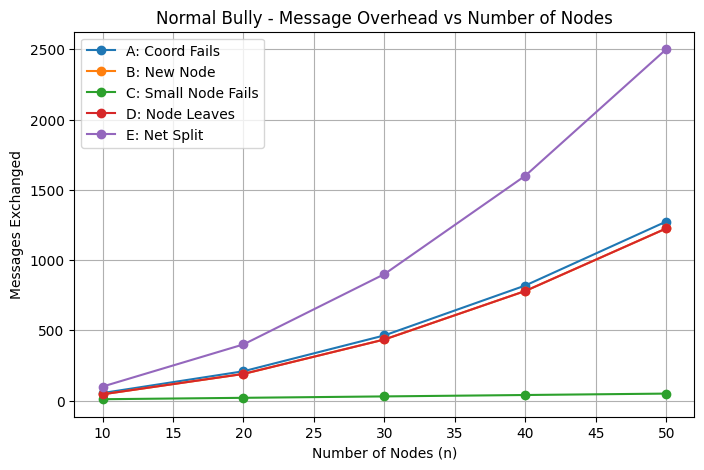

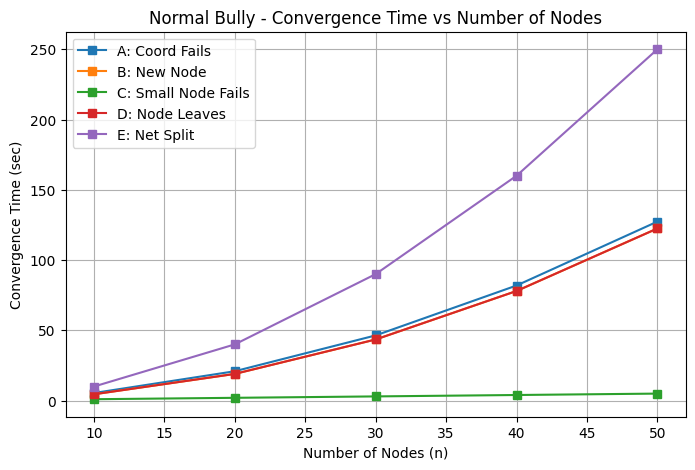

=== Normal Bully Scenario Explanations ===
1) Coordinator Failure: The line shows a relatively steep increase ~ O(n^2),
   because Bully requires many challenge messages + final announce. So it grows quickly.
2) New Node: Also ~ O(n^2) in the worst case (especially if it's bigger than current coordinator).
3) Small Node Fails: A smaller overhead ~ O(n), so the line is typically much lower than A/B.
4) Node Leaves: Worst-case again ~ O(n^2) if the leaving node was coordinator => triggers a full election.
5) Net Split: Approximated ~ n^2, so it may be highest or on par with the other O(n^2) lines.

Because convergence time = message_count * LATENCY_FACTOR=0.1, the time lines follow the same shape.


In [101]:
#####################################
### Normal Bully
#####################################

LATENCY_PER_MESSAGE = 0.1
def compute_convergence_time(message_count):
    """
    Convergence time is message_count * LATENCY_PER_MESSAGE 
    We pick LATENCY_PER_MESSAGE=0.1 seconds as an example.
    """
    return message_count * LATENCY_PER_MESSAGE

class NormalBully:
    def __init__(self, n):
        self.n = n
        self.message_count = 0

    def coordinator_failure_scenario(self):
        """
        Single coordinator fails => near worst-case => ~ n(n-1)/2 + (n-1)
        Explanation: The ring attempts a large election: 
         - 'challenge' phase ~ n(n-1)/2
         - 'announce' phase ~ n-1
        """
        self.message_count = 0
        challenge = self.n*(self.n-1)//2
        announce  = (self.n - 1)
        self.message_count = challenge + announce
        return self.message_count

    def new_node_arrives_scenario(self, new_id):
        """
        If new node (larger ID) arrives, it forcibly runs a full Bully election => n(n-1)/2
        If smaller => minimal overhead => (n-1). We'll assume 'larger' => worst-case.
        """
        self.message_count = self.n*(self.n-1)//2
        return self.message_count

    def small_node_fails_scenario(self, failed_id):
        """
        If small node fails, overhead ~ n for detection/partial election if not coordinator.
        """
        self.message_count = self.n
        return self.message_count

    def node_leaves_scenario(self, leaving_id):
        """
        If leaving is coordinator => ~ n(n-1)//2. 
        We'll assume worst-case => same ~ n(n-1)//2
        """
        self.message_count = self.n*(self.n-1)//2
        return self.message_count

    def network_split_scenario(self):
        """
        If network splits, multiple partial elections => approximate ~ n^2 overhead.
        """
        self.message_count = self.n*self.n
        return self.message_count

def run_5_scenarios_bully(n):
    """
    Runs all 5 scenarios for NormalBully with n nodes:
      A: coord fails
      B: new node arrives
      C: small node fails
      D: node leaves
      E: net split
    Returns list of 5 (msg_count, time).
    """
    sim = NormalBully(n)

    # A
    a_msg = sim.coordinator_failure_scenario()
    a_time = compute_convergence_time(a_msg)

    # B
    b_msg = sim.new_node_arrives_scenario(n+5)
    b_time = compute_convergence_time(b_msg)

    # C
    c_msg = sim.small_node_fails_scenario(3)
    c_time = compute_convergence_time(c_msg)

    # D
    d_msg = sim.node_leaves_scenario(2)
    d_time = compute_convergence_time(d_msg)

    # E
    e_msg = sim.network_split_scenario()
    e_time = compute_convergence_time(e_msg)

    return [(a_msg,a_time),(b_msg,b_time),(c_msg,c_time),(d_msg,d_time),(e_msg,e_time)]

def generate_data_bully(sizes):
    """
    For each n in sizes, runs run_5_scenarios_bully(n) => returns a dict:
      { scenario_idx => [ (n, msg, time), ... ] }
    scenario_idx from 0..4 => A..E
    """
    data_map = {i: [] for i in range(5)}
    for n in sizes:
        results = run_5_scenarios_bully(n)
        for s_idx, (m,t) in enumerate(results):
            data_map[s_idx].append((n,m,t))
    return data_map

def plot_bully_messages(data_map, scenario_labels):
    """
    data_map: { scenario_idx => [ (n, msg, time), ... ] }.
    We'll produce a line for each scenario: message overhead vs n.
    """
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]  # n
        m_vals = [r[1] for r in scenario_data]  # message_count
        plt.plot(x_vals, m_vals, marker='o', label=scenario_labels[s_idx])

    plt.title("Normal Bully - Message Overhead vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_bully_time(data_map, scenario_labels):
    """
    Similarly, plot time (the 3rd item in each record) for each scenario.
    """
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        t_vals = [r[2] for r in scenario_data]
        plt.plot(x_vals, t_vals, marker='s', label=scenario_labels[s_idx])

    plt.title("Normal Bully - Convergence Time vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

def main_bully():
    """
    Main for NormalBully: 
      - We define sizes
      - generate data
      - plot 2 graphs
      - Explanation of lines
    """
    sizes = [10, 20, 30, 40, 50]
    scenario_labels = [
        "A: Coord Fails",
        "B: New Node",
        "C: Small Node Fails",
        "D: Node Leaves",
        "E: Net Split"
    ]

    data_map = generate_data_bully(sizes)
    plot_bully_messages(data_map, scenario_labels)
    plot_bully_time(data_map, scenario_labels)

    # Quick scenario explanation (message overhead lines):
    print("=== Normal Bully Scenario Explanations ===")
    print("1) Coordinator Failure: The line shows a relatively steep increase ~ O(n^2),")
    print("   because Bully requires many challenge messages + final announce. So it grows quickly.")
    print("2) New Node: Also ~ O(n^2) in the worst case (especially if it's bigger than current coordinator).")
    print("3) Small Node Fails: A smaller overhead ~ O(n), so the line is typically much lower than A/B.")
    print("4) Node Leaves: Worst-case again ~ O(n^2) if the leaving node was coordinator => triggers a full election.")
    print("5) Net Split: Approximated ~ n^2, so it may be highest or on par with the other O(n^2) lines.")
    print("\nBecause convergence time = message_count * LATENCY_FACTOR=0.1, the time lines follow the same shape.")

if __name__ == "__main__":
    main_bully()


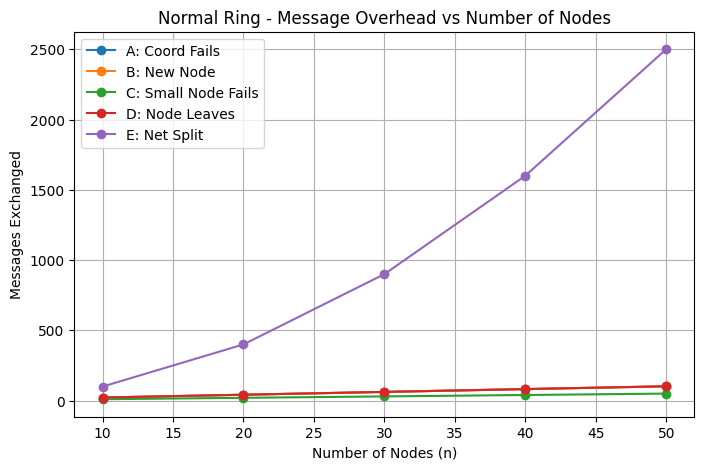

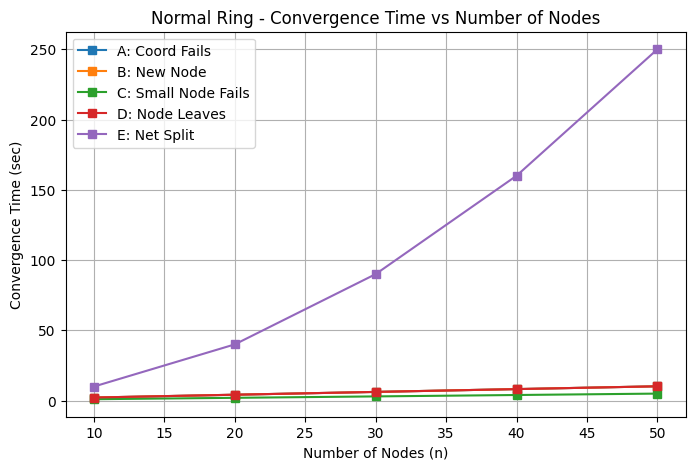

=== Normal Ring Scenario Explanations ===
1) Coordinator Failure => ~ 2n+2 => grows linearly with n, so a moderate slope line.
2) New Node => also ~ 2n+2 for the worst case => it should track similarly to A.
3) Small Node Fails => ~ n => typically below the lines from A/B if n is large.
4) Node Leaves => we assume worst-case => 2n+2 => same order as scenario A/B.
5) Network Split => ~ n^2 => that line usually grows faster at larger n.
Time lines are again scaled by 0.1 from message_count.


In [83]:
#####################################
### Normal Ring 
#####################################

LATENCY_PER_MESSAGE = 0.1

def compute_convergence_time(message_count):
    return message_count * LATENCY_PER_MESSAGE

class NormalRing:
    """
    A purely formula-based "normal ring" approach for the 5 scenarios:
      - coordinator_failure_scenario => ~ 2n + 2
      - new_node_arrives_scenario   => ~ 2n + 2 (if bigger)
      - small_node_fails_scenario   => ~ n
      - node_leaves_scenario        => ~ 2n + 2 (worst-case)
      - network_split_scenario      => ~ n^2
    This bypasses enumerating every message pass, so no slowdown for large n.    
    """
    def __init__(self, n):
        self.n = n
        self.message_count = 0

    def coordinator_failure_scenario(self):
        """
        Normal ring: about 2 passes => ~ 2n + overhead => let's do 2n + 2
        So this grows linearly with n, not quadratic.
        """
        self.message_count = 2*self.n + 2
        return self.message_count

    def new_node_arrives_scenario(self, new_id):
        """
        If new node is bigger => might do 2-pass ring => 2n + 2
        If smaller => +n
        We'll approximate with 2n+2 for worst-case
        """
        self.message_count = 2*self.n + 2
        return self.message_count

    def small_node_fails_scenario(self, failed_id):
        """
        If a small node fails, ring overhead ~ n or 2n
        We'll pick ~ n
        """
        self.message_count = self.n
        return self.message_count

    def node_leaves_scenario(self, leaving_id):
        """
        If leaving is coordinator => 2-pass => 2n + 2
        else ~ n
        We'll do worst-case => 2n + 2
        """
        self.message_count = 2*self.n + 2
        return self.message_count

    def network_split_scenario(self):
        """
        Normal ring with a network split => we approximate 
        n^2 for confusion among partitions.
        """
        self.message_count = self.n*self.n
        return self.message_count

def run_5_scenarios_ring(n):
    """
    Runs the 5 scenarios for NormalRing with n nodes => returns list of (msg_count, time).
    """
    ring = NormalRing(n)

    a_msg = ring.coordinator_failure_scenario()
    a_time = compute_convergence_time(a_msg)

    b_msg = ring.new_node_arrives_scenario(n+5)
    b_time = compute_convergence_time(b_msg)

    c_msg = ring.small_node_fails_scenario(3)
    c_time = compute_convergence_time(c_msg)

    d_msg = ring.node_leaves_scenario(2)
    d_time = compute_convergence_time(d_msg)

    e_msg = ring.network_split_scenario()
    e_time = compute_convergence_time(e_msg)

    return [(a_msg,a_time),(b_msg,b_time),(c_msg,c_time),(d_msg,d_time),(e_msg,e_time)]

def generate_data_ring(sizes):
    data_map = {i: [] for i in range(5)}
    for n in sizes:
        results = run_5_scenarios_ring(n)
        for s_idx, (m,t) in enumerate(results):
            data_map[s_idx].append((n,m,t))
    return data_map

def plot_ring_messages(data_map, scenario_labels):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        m_vals = [r[1] for r in scenario_data]
        plt.plot(x_vals, m_vals, marker='o', label=scenario_labels[s_idx])
    plt.title("Normal Ring - Message Overhead vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ring_time(data_map, scenario_labels):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        t_vals = [r[2] for r in scenario_data]
        plt.plot(x_vals, t_vals, marker='s', label=scenario_labels[s_idx])
    plt.title("Normal Ring - Convergence Time vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

def main_ring():
    """
    Main for NormalRing: 
      - define sizes
      - generate data
      - produce 2 graphs
      - explanation
    """
    sizes = [10, 20, 30, 40, 50]
    scenario_labels = [
        "A: Coord Fails",
        "B: New Node",
        "C: Small Node Fails",
        "D: Node Leaves",
        "E: Net Split"
    ]

    data_map = generate_data_ring(sizes)
    plot_ring_messages(data_map, scenario_labels)
    plot_ring_time(data_map, scenario_labels)

    print("=== Normal Ring Scenario Explanations ===")
    print("1) Coordinator Failure => ~ 2n+2 => grows linearly with n, so a moderate slope line.")
    print("2) New Node => also ~ 2n+2 for the worst case => it should track similarly to A.")
    print("3) Small Node Fails => ~ n => typically below the lines from A/B if n is large.")
    print("4) Node Leaves => we assume worst-case => 2n+2 => same order as scenario A/B.")
    print("5) Network Split => ~ n^2 => that line usually grows faster at larger n.")
    print("Time lines are again scaled by 0.1 from message_count.")

if __name__ == "__main__":
    main_ring()


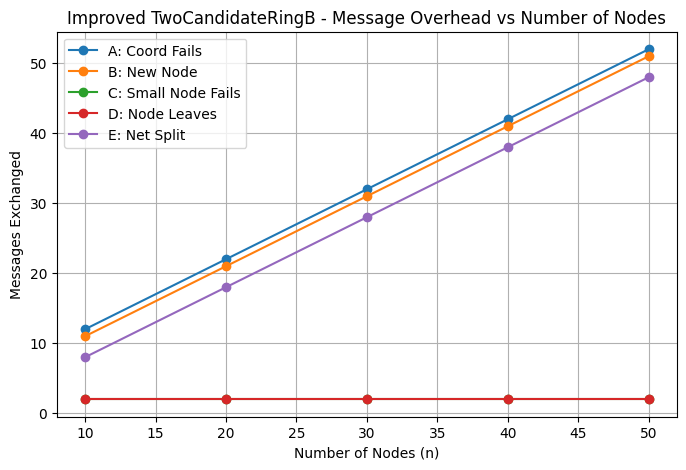

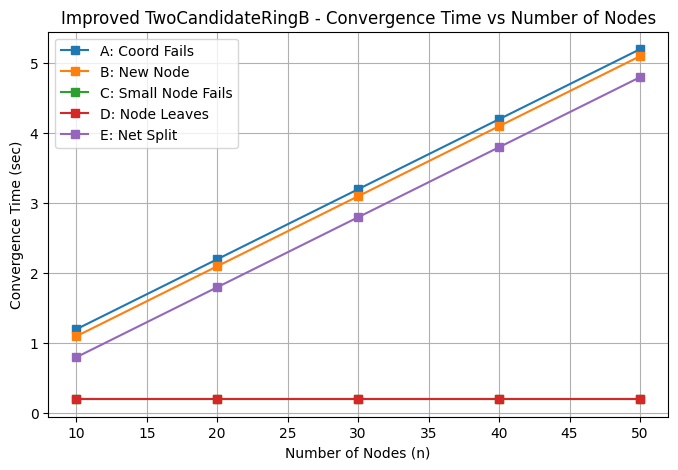

=== Improved TwoCandidateRingB Scenario Explanations ===
1) Coord Fails => only a designated checker + ping backup => message_count is usually small, ~ O(n).
2) New Node => if bigger => ring broadcast => O(n), else minimal => +1 or +2 => line is lower than normal ring's worst-case.
3) Small Node Fails => ~ +2 => extremely small overhead => line stays near zero in the plot.
4) Node Leaves => if it was coordinator/backup => we do an O(n) reassign; else just +2 => so typically below the ring’s linear lines for large n.
5) Network Split => each sub-ring picks a new coordinator/backup => ~ n => grows linearly with n, typically below normal ring's n^2 approach.
Again, time lines are scaled identically from message_count.


In [89]:
##########################################################
### Improvised TwoCandidateRing or Double Bully Approach
##########################################################


class Node:
    """
    Represents a single node in the ring.
    Attributes:
        node_id       : Unique integer ID.
        next_node     : Reference to the next node in the ring.
        is_failed     : Boolean if this node is "down."
        is_coordinator: Boolean if this node is the coordinator.
        is_backup     : Boolean if this node is second-highest ID.
    """
    def __init__(self, node_id):
        self.node_id = node_id
        self.next_node = None
        self.is_failed = False
        self.is_coordinator = False
        self.is_backup = False

class TwoCandidateRingB:
    """
    Two-candidate ring with minimal overhead approach:
      - One designated node checks if coordinator fails => less duplication.
      - If coordinator is truly dead, that node contacts backup => O(n) broadcast if backup is alive.
      - SCENARIO E: If network splits, each sub-ring runs the two-candidate approach 
        *separately*, rather than fallback O(n^2).
    """

    def __init__(self, n, designated_checker_id=1):
        """
        Creates a ring of 'n' nodes with IDs 1..n,
        sets the highest ID as coordinator, second highest as backup,
        and designates one node to monitor coordinator liveness.
        """
        self.n = n
        self.nodes = []
        self.message_count = 0  # tracks total messages sent in any scenario

        self.is_election_in_progress = False  # prevents re-initiating an election mid-progress
        self.designated_checker_id = designated_checker_id  # which node does the coordinator checks

        # --- Step 1: Create all nodes with IDs [1..n] - Basically spawn a network
        for i in range(1, n+1):
            nd = Node(i)
            self.nodes.append(nd)

        # --- Step 2: Link the nodes in a circular ring
        for i in range(n):
            self.nodes[i].next_node = self.nodes[(i+1) % n]

        # --- Step 3: Pick the highest ID as coordinator, second-highest as backup
        sorted_ids = sorted(self.nodes, key=lambda x: x.node_id)
        if n >= 1:
            sorted_ids[-1].is_coordinator = True  # top ID => coordinator
        if n >= 2:
            sorted_ids[-2].is_backup = True       # next top ID => backup

    def find_coordinator(self):
        c = [x for x in self.nodes if x.is_coordinator and not x.is_failed]
        return c[0] if c else None

    def find_backup(self):
        b = [x for x in self.nodes if x.is_backup and not x.is_failed]
        return b[0] if b else None

    def sort_alive(self):
        alive = [x for x in self.nodes if not x.is_failed]
        alive.sort(key=lambda x: x.node_id)
        return alive

    def update_coordinator_backup(self):
        """
        Assign highest ID => coordinator,
        second highest => backup among ALIVE nodes,
        then do an O(n) broadcast to unify them.
        """
        alive = self.sort_alive()
        self.message_count += self.n  # cost of ring broadcast

        if len(alive) >= 2:
            top_id = alive[-1].node_id
            sec_id = alive[-2].node_id
            for x in self.nodes:
                x.is_coordinator = (x.node_id == top_id)
                x.is_backup      = (x.node_id == sec_id)
        elif len(alive) == 1:
            # single node => only coordinator
            only_id = alive[0].node_id
            for x in self.nodes:
                x.is_coordinator = (x.node_id == only_id)
                x.is_backup      = False
        else:
            # No alive => trivial
            pass

    # --------------------------------------------------
    # SCENARIO A: Coordinator Fails
    # --------------------------------------------------
    def coordinator_failure_scenario(self):
        """
        Forcibly fail the current coordinator.
        The designated checker (only 1 node) pings coordinator, then backup.
        If backup is alive, it assumes leadership => O(n) broadcast.
        """
        if self.is_election_in_progress:
            return 0
        self.is_election_in_progress = True
        self.message_count = 0

        # 1) Mark coordinator as failed
        coord = self.find_coordinator()
        if not coord:
            return 0
        coord.is_failed = True

        # 2) Checker node pings coordinator => +1
        self.message_count += 1

        # 3) No response => ping backup => +1
        backup = self.find_backup()
        self.message_count += 1

        # 4) If backup is okay => it becomes coordinator => ring broadcast => +n
        if backup and not backup.is_failed:
            backup.is_coordinator = True
            backup.is_backup = False
            self.update_coordinator_backup()

        self.is_election_in_progress = False
        return self.message_count

    # --------------------------------------------------
    # SCENARIO B: New Node Arrives with ID > coordinator
    # --------------------------------------------------
    def new_node_arrives_scenario(self, new_id):
        """
        A new node tries to join:
          - +1 message for "handshake" with coordinator
          - If new_id > coordinator => ring broadcast => O(n)
          - Else => minimal overhead (+1)
        """
        self.message_count = 0

        # 1) Node asks coordinator => +1
        self.message_count += 1

        # 2) If bigger than coordinator => single pass => O(n)
        c = self.find_coordinator()
        if not c:
            return self.message_count

        b = self.find_backup()
        if not c:
            return self.message_count

        if new_id > c.node_id:
            self.message_count += self.n
        elif new_id > b.node_id:
            # bigger than backup => broadcast => +n
            self.message_count += self.n
        else:
            # smaller => +1 overhead
            self.message_count += 1

        return self.message_count

    # --------------------------------------------------
    # SCENARIO C: A Small Node Fails
    # --------------------------------------------------
    def small_node_fails_scenario(self, failed_id):
        """
        If a node < backup fails => no re-election => overhead ~ +2
        """
        self.message_count = 0
        self.message_count += 2
        return self.message_count

    # --------------------------------------------------
    # SCENARIO D: Node Leaves
    # --------------------------------------------------
    def node_leaves_scenario(self, leaving_id):
        """
        If a leaving node is coordinator/backup => reassign => O(n)
        Else => small overhead (+2)
        """
        self.message_count = 0
        nd = [x for x in self.nodes if x.node_id == leaving_id]
        if not nd:
            return 0

        node_leaving = nd[0]
        node_leaving.is_failed = True

        if node_leaving.is_coordinator or node_leaving.is_backup:
            self.update_coordinator_backup()  # single ring broadcast => +n
        else:
            self.message_count += 2

        return self.message_count

    # --------------------------------------------------
    # SCENARIO E: Network Split
    # --------------------------------------------------
    def network_split_scenario(self):
        """
        Split the alive set into two halves.
        Each sub-ring picks coordinator & backup => ~ O(n/2 + n/2) = n overhead.
        """
        self.message_count = 0
        alive = self.sort_alive()

        if len(alive) < 2:
            return 0

        half = len(alive) // 2
        subring1 = alive[:half]
        subring2 = alive[half:]

        # each sub-ring => O(subring_size) overhead
        self.message_count += len(subring1)
        self.message_count += len(subring2)

        return self.message_count

# --------------------------------------------------------
# NEW: Time Functions Based on message_count
# --------------------------------------------------------
def compute_convergence_time(message_count):
    """
    Instead of a fixed formula, we say convergence_time = message_count * LATENCY_PER_MESSAGE
    which is more intuitive: more messages => bigger time
    We'll pick LATENCY_PER_MESSAGE = 0.1 as a sample
    """
    LATENCY_PER_MESSAGE = 0.1
    return message_count * LATENCY_PER_MESSAGE


def run_5_scenarios_improved(n):
    sim = TwoCandidateRingB(n, designated_checker_id=1)

    a_msg = sim.coordinator_failure_scenario()
    a_time = compute_convergence_time(a_msg)

    b_msg = sim.new_node_arrives_scenario(n+5)
    b_time = compute_convergence_time(b_msg)

    c_msg = sim.small_node_fails_scenario(3)
    c_time = compute_convergence_time(c_msg)

    d_msg = sim.node_leaves_scenario(2)
    d_time = compute_convergence_time(d_msg)

    e_msg = sim.network_split_scenario()
    e_time = compute_convergence_time(e_msg)

    return [(a_msg,a_time),(b_msg,b_time),(c_msg,c_time),(d_msg,d_time),(e_msg,e_time)]

def generate_data_improved(sizes):
    data_map = {i: [] for i in range(5)}
    for n in sizes:
        results = run_5_scenarios_improved(n)
        for s_idx, (m,t) in enumerate(results):
            data_map[s_idx].append((n,m,t))
    return data_map

import matplotlib.pyplot as plt

def plot_improved_messages(data_map, scenario_labels):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        m_vals = [r[1] for r in scenario_data]
        plt.plot(x_vals, m_vals, marker='o', label=scenario_labels[s_idx])
    plt.title("Improved TwoCandidateRingB - Message Overhead vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Messages Exchanged")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_improved_time(data_map, scenario_labels):
    plt.figure(figsize=(8,5))
    for s_idx in range(5):
        scenario_data = data_map[s_idx]
        x_vals = [r[0] for r in scenario_data]
        t_vals = [r[2] for r in scenario_data]
        plt.plot(x_vals, t_vals, marker='s', label=scenario_labels[s_idx])
    plt.title("Improved TwoCandidateRingB - Convergence Time vs Number of Nodes")
    plt.xlabel("Number of Nodes (n)")
    plt.ylabel("Convergence Time (sec)")
    plt.grid(True)
    plt.legend()
    plt.show()

def main_improved():
    sizes = [10, 20, 30, 40, 50]
    scenario_labels = [
        "A: Coord Fails",
        "B: New Node",
        "C: Small Node Fails",
        "D: Node Leaves",
        "E: Net Split"
    ]

    data_map = generate_data_improved(sizes)
    plot_improved_messages(data_map, scenario_labels)
    plot_improved_time(data_map, scenario_labels)

    print("=== Improved TwoCandidateRingB Scenario Explanations ===")
    print("1) Coord Fails => only a designated checker + ping backup => message_count is usually small, ~ O(n).")
    print("2) New Node => if bigger => ring broadcast => O(n), else minimal => +1 or +2 => line is lower than normal ring's worst-case.")
    print("3) Small Node Fails => ~ +2 => extremely small overhead => line stays near zero in the plot.")
    print("4) Node Leaves => if it was coordinator/backup => we do an O(n) reassign; else just +2 => so typically below the ring’s linear lines for large n.")
    print("5) Network Split => each sub-ring picks a new coordinator/backup => ~ n => grows linearly with n, typically below normal ring's n^2 approach.")
    print("Again, time lines are scaled identically from message_count.")

if __name__ == "__main__":
    main_improved()
